# Final Project

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
def acc_loss(history, pdir):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['accuracy'], label='Training')
    ax1.plot(history['val_accuracy'], label='Validation')
    ax1.grid()
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('epoch', fontsize=12)
    ax1.set_ylabel('accuracy', fontsize=12)
    ax1.legend(loc='top left')
    ax2.plot(history['loss'], label='Training')
    ax2.plot(history['val_loss'], label='Validation')
    ax2.grid()
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('epoch', fontsize=12)
    ax2.set_ylabel('loss', fontsize=12)
    ax2.legend(loc='top left')
    fig.suptitle('Training result', fontsize=18)
    fig.savefig(pdir, bbox_inches='tight')

In [4]:
imgX, imgY, num_classes = 224, 224, 2

## image data generator: resize...etc.
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.15,
    rotation_range=10,
    zoom_range=0.1,
    validation_split=0.15    # validation split from training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 64
train_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(imgX, imgY),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'    # originated from train_datagen set as「training data」.
)

val_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(imgX, imgY),
    batch_size=1,
    class_mode='binary',
    shuffle=False,
    subset='validation'    ## originated from train_datagen set as「validation data」.
)

test_generator = test_datagen.flow_from_directory(
    directory='test', 
    target_size=(imgX, imgY),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
def model_result(predict, name, test=test_generator.classes):
    mat1 = confusion_matrix(test, predict)
    sns.heatmap(mat1.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=train_generator.class_indices,
                yticklabels=train_generator.class_indices, cmap="YlGnBu")
    accuracy = np.sum(test == predict) / len(test)
    plt.xlabel('Original', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.title(str(name) + ' ACC:' + str(round(accuracy,4)))
    plt.savefig('./images/' + name + '_result.png', bbox_inches='tight')
    tn, fp, fn, tp = confusion_matrix(test, predict).ravel()
    recall  = round((tp / (tp + fn)), 4) # sensitivity
    precision  = round((tn / (tn + fp)), 4) # specificity
    f1 = round((2 / (1/recall + 1/precision)), 4)
    report = {name: [accuracy, recall, precision, f1]}
    report = pd.DataFrame(report, index=['Accuracy', 'Recall', 'Precision', 'F1'])
    print(report)

# References:

https://www.tensorflow.org/guide/keras/save_and_serialize

https://blog.csdn.net/weixin_30826761/article/details/95509779

https://blog.csdn.net/sinat_26917383/article/details/72859145

https://blog.csdn.net/sunbaigui/article/details/50807418

https://blog.csdn.net/langb2014/article/details/52787095

https://blog.csdn.net/cv_family_z/article/details/50789805

https://blog.csdn.net/qq_36330643/article/details/77367709

https://blog.csdn.net/wmy199216/article/details/71171401 

https://blog.csdn.net/weixin_41967600/article/details/105616647#GoogleNet%C2%A0

https://keras-cn.readthedocs.io/en/latest/other/application/

https://gist.github.com/baraldilorenzo/8d096f48a1be4a2d660d

In [6]:
from numba import cuda
cuda.select_device(0)
cuda.close()

##### 關於BFC算法：
##### 將內存分塊管理，按塊進行空間分配和釋放。
##### 通過split操作將大內存塊分解成用戶需要的小內存塊。
##### 通過merge操作合併小的內存塊，做到內存碎片回收
##### 通過bin這個抽象數據結構實現對空閒塊高效管理。

In [7]:
from keras.backend.tensorflow_backend import set_session

config=tf.compat.v1.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
tf.compat.v1.keras.backend.set_session(config)

### AlexNet

In [ ]:
model = Sequential()
model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), padding='valid',
                 activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same',activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

model.add(BatchNormalization())
#     model.add(Dense(512, activation='sigmoid'))
#     model.add(Dropout(0.25))
#     model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.binary_crossentropy, 'accuracy'])

print(model.summary())

In [9]:
np.random.seed(101)
model_ckpt = ModelCheckpoint('./models/Alexnet_Adam.h5', monitor='val_acc', save_best_only=True)

# set_session(tf.Session(config=config))
start = time.time()

model_alexnet = model.fit(train_generator,
                          epochs=15,
                          validation_data=val_generator,
                          callbacks=[model_ckpt])
end = time.time()

print('\nAlexNet: {0} seconds.'.format(end - start))
model.save('./models/Alexnet_Adam_last.h5')

history_alexnet = pd.DataFrame(model_alexnet.history)
with open('./history/Alexnet_Adam_hist.json', 'w') as f:
    history_alexnet.to_json(f)

Epoch 1/15
70/70 [==============================] - 95s 1s/step - loss: 0.7787 - binary_crossentropy: 0.7745 - accuracy: 0.5940 - val_loss: 0.5187 - val_binary_crossentropy: 0.6129 - val_accuracy: 0.7430
Epoch 2/15
70/70 [==============================] - 83s 1s/step - loss: 0.4831 - binary_crossentropy: 0.4846 - accuracy: 0.8006 - val_loss: 0.5264 - val_binary_crossentropy: 0.6126 - val_accuracy: 0.7430
Epoch 3/15
70/70 [==============================] - 83s 1s/step - loss: 0.3382 - binary_crossentropy: 0.3382 - accuracy: 0.8877 - val_loss: 0.5004 - val_binary_crossentropy: 0.6033 - val_accuracy: 0.7430
Epoch 4/15
70/70 [==============================] - 82s 1s/step - loss: 0.3037 - binary_crossentropy: 0.3039 - accuracy: 0.9023 - val_loss: 0.4541 - val_binary_crossentropy: 0.5754 - val_accuracy: 0.7468
Epoch 5/15
70/70 [==============================] - 83s 1s/step - loss: 0.2688 - binary_crossentropy: 0.2628 - accuracy: 0.9172 - val_loss: 0.4174 - val_binary_crossentropy: 0.4652 - v

In [25]:
hist = model_alexnet.history
print('Average Training Accuracy', np.average(hist['accuracy']))
print('Average Validation Accuracy', np.average(hist['val_accuracy']))

Average Training Accuracy 0.90870553
Average Validation Accuracy 0.8534526864687602


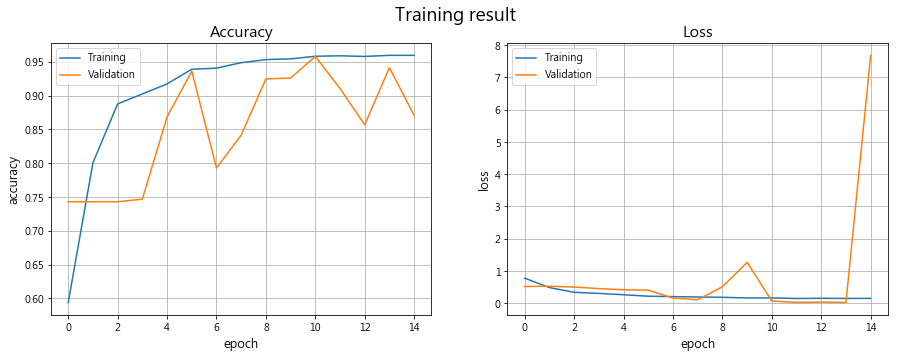

In [26]:
acc_loss(hist, './images/Alexnet_Adam.png')

In [10]:
score = model.evaluate(test_generator, verbose=1)
print('AlexNet - Test loss:', score[0])
print('AlexNet - Test accuracy:', score[2])
predict = np.ravel(model.predict_classes(test_generator, batch_size=None, verbose=0))

624/624 [==============================] - 12s 19ms/step
AlexNet - Test loss: 0.5880874395370483
AlexNet - Test accuracy: 0.9230769276618958


           AlexNet_Adam
Accuracy       0.923077
Recall         0.930800
Precision      0.910300
F1             0.920400


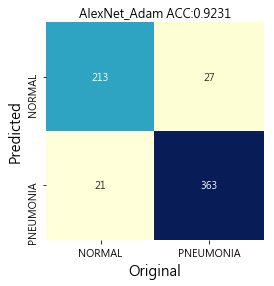

In [11]:
model_result(predict, 'AlexNet_Adam')

In [8]:
model = load_model('./models/Alexnet_Adam_last.h5')

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.binary_crossentropy, 'accuracy'])

### VGG19

In [12]:
from keras.applications.vgg19 import VGG19

In [19]:
model = Sequential()

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

model.add(vgg_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001), 
              metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 32)               

In [20]:
np.random.seed(101)
# earlystop = EarlyStopping(monitor='val_acc', patience=5, mode='max', verbose=1)
model_ckpt = ModelCheckpoint(filepath='./models/Vgg19_Adam.h5', monitor='val_acc', save_best_only=True)

start = time.time()

model_vgg19 = model.fit(train_generator, 
                        epochs=15,
                        validation_data=val_generator,
                        callbacks=[model_ckpt])

end = time.time()
print('\nVGG19 took {0} seconds.'.format(end - start))

model.save('./models/Vgg19_Adam_last.h5')

history_vgg19 = pd.DataFrame(model_vgg19.history)
with open('./history/Vgg19_Adam_hist.json', 'w') as f:
    history_vgg19.to_json(f)

Epoch 1/15
70/70 [==============================] - 99s 1s/step - loss: 0.4261 - binary_crossentropy: 0.4263 - accuracy: 0.8218 - val_loss: 0.7737 - val_binary_crossentropy: 0.6181 - val_accuracy: 0.6240
Epoch 2/15
70/70 [==============================] - 89s 1s/step - loss: 0.3181 - binary_crossentropy: 0.3195 - accuracy: 0.8884 - val_loss: 0.9453 - val_binary_crossentropy: 0.4830 - val_accuracy: 0.8632
Epoch 3/15
70/70 [==============================] - 92s 1s/step - loss: 0.2697 - binary_crossentropy: 0.2718 - accuracy: 0.9109 - val_loss: 0.4060 - val_binary_crossentropy: 0.3359 - val_accuracy: 0.9297
Epoch 4/15
70/70 [==============================] - 88s 1s/step - loss: 0.2542 - binary_crossentropy: 0.2527 - accuracy: 0.9231 - val_loss: 0.6444 - val_binary_crossentropy: 0.2304 - val_accuracy: 0.9565
Epoch 5/15
70/70 [==============================] - 88s 1s/step - loss: 0.2290 - binary_crossentropy: 0.2271 - accuracy: 0.9375 - val_loss: 0.1578 - val_binary_crossentropy: 0.1882 - v

In [31]:
hist = model_vgg19.history
print('Average Training Accuracy', np.average(hist['accuracy']))
print('Average Validation Accuracy', np.average(hist['val_accuracy']))

Average Training Accuracy 0.94242966
Average Validation Accuracy 0.9309462944666544


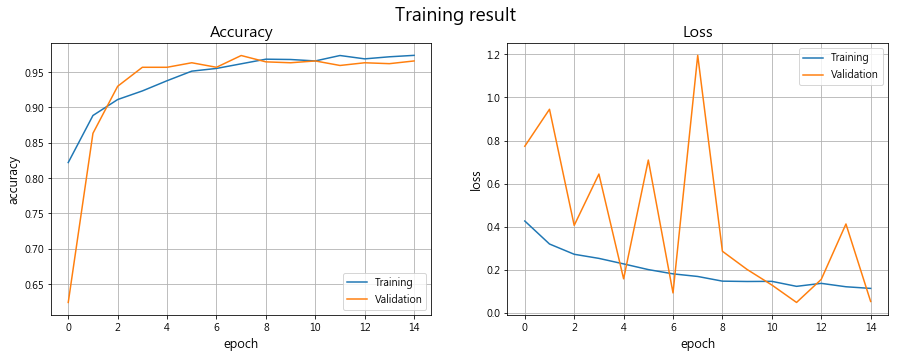

In [32]:
acc_loss(hist, './images/Vgg19_Adam.png')

In [15]:
score = model.evaluate(test_generator, verbose=1)
print('Vgg19 - Test loss:', score[0])
print('Vgg19 - Test accuracy:', score[2])
predict = (model.predict_classes(test_generator, batch_size = None, verbose=0)).ravel()

624/624 [==============================] - 13s 20ms/step
Vgg19 - Test loss: 0.019687414169311523
Vgg19 - Test accuracy: 0.8846153616905212


           Vgg19_Adam
Accuracy     0.884615
Recall       0.984600
Precision    0.717900
F1           0.830400


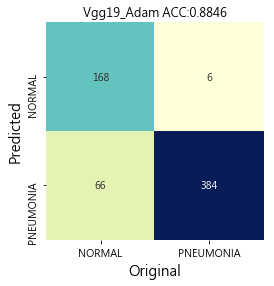

In [16]:
model_result(predict, 'Vgg19_Adam')

In [13]:
model = load_model('./models/Vgg19_Adam_last.h5')

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001), 
              metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])